<a href="https://colab.research.google.com/github/mahrukhS/Data-Modelling/blob/main/Evasion_Poisoning_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  # **Impact of Evasion and Poisoning Attacks on the Performance of ML Models**







## *Importing Libraries*

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_fscore_support, roc_auc_score
from matplotlib import pyplot as plt

## *Data Loading and Preprocessing*

In [2]:
# Load training data
df_train = pd.read_csv('training.csv')
df_test = pd.read_csv('testing.csv')

# Drop rows with NaN/missing values
df_train = df_train.dropna()
df_test = df_test.dropna()

# Shuffle training data
df_train = shuffle(df_train)

#Shuffle testing data
df_test = shuffle(df_test)

print(df_train['Label'].nunique())
print(df_train['Label'].unique())

#split the features and target
X_train = df_train.drop('Label', axis=1)
y_train = df_train['Label']

X_test = df_test.drop('Label', axis=1)
y_test = df_test['Label']

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Split train into train-valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

7
['PortScan' 'Bot' 'Dos/DDos' 'Normal' 'Brute Force' 'Web Attack'
 'Infiltration']


# **Performance of Naive Bayes Model Before and After Attacks**

## *Naive Bayes*

In [3]:
# Train Naive Bayes
nb_model = GaussianNB()

# Cross validation with 5 folds
cv_scores = cross_validate(nb_model, X_train, y_train,
                         cv=5, scoring='accuracy')

print("CV mean:", cv_scores['test_score'].mean())
print("CV std:", cv_scores['test_score'].std())

nb_model.fit(X_train, y_train)

# Predict on validation set
nb_pred = nb_model.predict(X_val)

# Evaluate accuracy
nb_accuracy = accuracy_score(y_val, nb_pred)

print("Validation Accuracy: ", nb_accuracy)

# Retrain on full train data
nb_model.fit(X_train, y_train)

# Predict on test data
nb_test_pred = nb_model.predict(X_test)

# Evaluate accuracy on test set
nb_test_accuracy = accuracy_score(y_test, nb_test_pred)

nb_precision, nb_recall, nb_f1, _ = precision_recall_fscore_support(y_test, nb_test_pred)


print("Original Accuracy: ", nb_test_accuracy)
print("Precision:", nb_precision.mean())
print("Recall:", nb_recall.mean())
print("F1 Score:", nb_f1.mean())

CV mean: 0.4082601499653206
CV std: 0.006382152909336033
Validation Accuracy:  0.4066771345465778
Original Accuracy:  0.40452415653870705
Precision: 0.2729628466710875
Recall: 0.6742786106089571
F1 Score: 0.21727213976632426


## *Performance of Naive Bayes After Launching an Evasion Attack*

After launching an evasion attack, the model performance has degraded as indicated by the slightly \decreased accuracy

In [4]:
# Choose a noise level for perturbation
epsilon = 185

# Create an adversarial test set
X_test_evas = X_test + epsilon * np.random.randn(*X_test.shape)

# Evaluate the model on the adversarial test set
y_test_pred = nb_model.predict(X_test_evas)

# Calculate accuracy
nb_evasion_accuracy = accuracy_score(y_test, y_test_pred)

print("Adversarial Accuracy (%):", nb_evasion_accuracy * 100)

Adversarial Accuracy (%): 40.43193890702352


## *Performance of Naive Bayes After Launching a Poisoning Attack*

The increase in model accuracy depicts a successful poisoning attack.

In [5]:
# Function to generate synthetic malicious examples
def generate_malicious_examples(num_examples=100, num_features=X_train.shape[1]):
    malicious_examples = np.random.normal(0, 1, size=(num_examples, num_features))
    malicious_labels = np.ones(num_examples)  # Assuming binary classification, label as 1
    return malicious_examples, malicious_labels

# Generate malicious examples
malicious_examples, malicious_labels = generate_malicious_examples(num_examples=100, num_features=X_train.shape[1])

# Inject malicious examples into the training set
X_train_poisoned = np.concatenate([X_train, malicious_examples])
y_train_poisoned = np.concatenate([y_train, malicious_labels])

nb_poisoned = GaussianNB()

# Retrain the model on the poisoned training set
nb_poisoned.fit(X_train_poisoned, y_train_poisoned)

# Evaluate the model on the test set after poisoning
poisoned_predictions = nb_poisoned.predict(X_test)
nb_poisoned_accuracy = accuracy_score(y_test, poisoned_predictions)

print("Accuracy After Poisoning:", nb_poisoned_accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Accuracy After Poisoning: 0.40456029197431975


## *Tabular Comparison for Naive Bayes Before and After Attacks*

In [6]:
import pandas as pd

# Create a DataFrame
data = {'Scenario': ['Original', 'After Evasion', 'After Poisoning'],
        'Accuracy': [nb_test_accuracy, nb_evasion_accuracy, nb_poisoned_accuracy]}

df = pd.DataFrame(data)

# Print the DataFrame
print(df)

          Scenario  Accuracy
0         Original  0.404524
1    After Evasion  0.404319
2  After Poisoning  0.404560


Although the accuracy has only decreased by a fraction. However, it has rightly depicted the decrease in model's performance after an evasion attack. A slight increase in model's performance after the poisoning attack depicts that the attack has been successful.

# **Performance of SVM Model Before and After Attacks**

## *Support Vector Machine*

In [7]:
#Training SVM
svm_model = svm.SVC(max_iter= 1000)
svm_model.fit(X_train, y_train)

# Predict on validation set
svm_pred = svm_model.predict(X_val)

#Evaluate the Accuracy
svm_accuracy = accuracy_score(y_val, svm_pred)
print("SVM Validation Accuracy: ", svm_accuracy)

# Retrain on full train data
svm_model.fit(X_train, y_train)

# Predict on test data
svm_test_pred = svm_model.predict(X_test)

# Evaluate test accuracy
svm_test_accuracy = accuracy_score(y_test, svm_test_pred)
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(y_test, svm_test_pred)

print("\nSVM Metrics")
print("Accuracy: ", svm_test_accuracy)
print("Precision:", svm_precision.mean())
print("Recall:", svm_recall.mean())
print("F1 Score:", svm_f1.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Validation Accuracy:  0.46322942675487144


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



SVM Metrics
Accuracy:  0.4591970706206863
Precision: 0.2965075816067485
Recall: 0.3400883853874837
F1 Score: 0.24908282353791034


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## *Performance of SVM After Launching an Evasion Attack*

After launching an evasion attack, the model performance has degraded as indicated by the slightly \decreased accuracy

In [8]:
# Choose a noise level for perturbation
epsilon = 5050

# Create an adversarial test set
X_test_evas = X_test + epsilon * np.random.randn(*X_test.shape)

# Evaluate the model on the adversarial test set
y_test_pred = svm_model.predict(X_test_evas)

# Calculate accuracy
svm_evasion_accuracy = accuracy_score(y_test, y_test_pred)

print("Adversarial Accuracy (%):", svm_evasion_accuracy * 100)

Adversarial Accuracy (%): 45.923320605629904


## *Performance of SVM After Launching a Poisoning Attack*
The increase in model accuracy depicts a successful poisoning attack.




In [9]:
# Function to generate synthetic malicious examples
def generate_malicious_examples(num_examples=100, num_features=X_train.shape[1]):
    malicious_examples = np.random.normal(0, 1, size=(num_examples, num_features))
    malicious_labels = np.ones(num_examples)  # Assuming binary classification, label as 1
    return malicious_examples, malicious_labels

# Generate malicious examples
malicious_examples, malicious_labels = generate_malicious_examples(num_examples=100, num_features=X_train.shape[1])

# Inject malicious examples into the training set
X_train_poisoned = np.concatenate([X_train, malicious_examples])
y_train_poisoned = np.concatenate([y_train, malicious_labels])

svm_poisoned = svm.SVC(max_iter=1000)


# Retrain the model on the poisoned training set
svm_poisoned.fit(X_train_poisoned, y_train_poisoned)

# Evaluate the model on the test set after poisoning
poisoned_predictions = svm_poisoned.predict(X_test)
svm_poisoned_accuracy = accuracy_score(y_test, poisoned_predictions)

print("Accuracy After Poisoning:", svm_poisoned_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Accuracy After Poisoning: 0.36723238698642513


## *Tabular Comparison for SVM Before and After Attacks*




In [10]:
import pandas as pd

# Create a DataFrame
data = {'Scenario': ['Original', 'After Evasion', 'After Poisoning'],
        'Accuracy': [svm_test_accuracy, svm_evasion_accuracy, svm_poisoned_accuracy]}

df = pd.DataFrame(data)

# Print the DataFrame
print(df)

          Scenario  Accuracy
0         Original  0.459197
1    After Evasion  0.459233
2  After Poisoning  0.367232


# **Performance of Decision Tree Model Before and After Attacks**


## *Decision Tree*

In [11]:
#Define Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=2)

#Train model on training data
dt_model.fit(X_train, y_train)

#Predict on validation data
dt_pred = dt_model.predict(X_val)

#Evaluate accuracy on validation data
dt_accuracy = accuracy_score(y_val, dt_pred)
print("Decision Tree Validation Accuracy:", dt_accuracy)

#Retrain on full training data
dt_model.fit(X_train, y_train)

#Predict on test data
dt_test_pred = dt_model.predict(X_test)

#Evaluate accuracy on test data
dt_test_accuracy = accuracy_score(y_test, dt_test_pred)
dt_precision, dt_recall, dt_f1, _ = precision_recall_fscore_support(y_test, dt_test_pred)

print("\nDecision Tree Metrics")
print("Accuracy:", dt_test_accuracy)
print("Precision:", dt_precision.mean())
print("Recall:", dt_recall.mean())
print("F1 Score:", dt_f1.mean())

Decision Tree Validation Accuracy: 0.8970115060876728

Decision Tree Metrics
Accuracy: 0.8935209163946471
Precision: 0.362341061241019
Recall: 0.40097780857099513
F1 Score: 0.3732308776031244


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## *Performance of Decision Tree After Launching an Evasion Attack*

After launching an evasion attack, the model performance has degraded as indicated by the decreased accuracy



In [12]:
# Choose a noise level for perturbation
epsilon = 100

# Create an adversarial test set
X_test_evas = X_test + epsilon * np.random.randn(*X_test.shape)

# Evaluate the model on the adversarial test set
y_test_pred = dt_model.predict(X_test_evas)

# Calculate accuracy
dt_evasion_accuracy = accuracy_score(y_test, y_test_pred)

print("Adversarial Accuracy (%):", dt_evasion_accuracy * 100)

Adversarial Accuracy (%): 75.22313631490827


## *Performance of Decision Tree After Poisoning Attack*
Depending on the model and data complexity, the Poisoning attack may either increase model's performance or remain same as in this case


In [13]:
# Function to generate synthetic malicious examples
def generate_malicious_examples(num_examples=100, num_features=X_train.shape[1]):
    malicious_examples = np.random.normal(0, 1, size=(num_examples, num_features))
    malicious_labels = np.ones(num_examples)  # Assuming binary classification, label as 1
    return malicious_examples, malicious_labels

# Generate malicious examples
malicious_examples, malicious_labels = generate_malicious_examples(num_examples=100, num_features=X_train.shape[1])

# Inject malicious examples into the training set
X_train_poisoned = np.concatenate([X_train, malicious_examples])
y_train_poisoned = np.concatenate([y_train, malicious_labels])

dt_poisoned = DecisionTreeClassifier(max_depth = 2)


# Retrain the model on the poisoned training set
dt_poisoned.fit(X_train_poisoned, y_train_poisoned)

# Evaluate the model on the test set after poisoning
poisoned_predictions = dt_poisoned.predict(X_test)
dt_poisoned_accuracy = accuracy_score(y_test, poisoned_predictions)

print("Accuracy After Poisoning:", dt_poisoned_accuracy)

Accuracy After Poisoning: 0.8935209163946471


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


## *Tabular Comparison for Decision Tree Before and After Attacks*



In [14]:
import pandas as pd

# Create a DataFrame
data = {'Scenario': ['Original', 'After Evasion', 'After Poisoning'],
        'Accuracy': [dt_test_accuracy, dt_evasion_accuracy, dt_poisoned_accuracy]}

df = pd.DataFrame(data)

# Print the DataFrame
print(df)

          Scenario  Accuracy
0         Original  0.893521
1    After Evasion  0.752231
2  After Poisoning  0.893521


# **Performance of Random Forest Model Before and After Attacks**

## *Random Forest*

In [15]:
# Define Random Forest model
rf_model = RandomForestClassifier(max_depth=3, n_estimators=3)

# Train on training data
rf_model.fit(X_train, y_train)

# Predict on validation data
rf_val_pred = rf_model.predict(X_val)

# Evaluate accuracy on validation set
rf_accuracy = accuracy_score(y_val, rf_val_pred)
print("Random Forest Validation Accuracy:", rf_accuracy)

# Retrain on full training data
rf_model.fit(X_train, y_train)

# Predict on test data
rf_test_pred = rf_model.predict(X_test)

# Evaluate accuracy on test set
rf_test_accuracy = accuracy_score(y_test, rf_test_pred)
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(y_test, rf_test_pred)

print("\nRandom Forest Metrics")
print("Accuracy:", rf_test_accuracy)
print("Precision:", rf_precision.mean())
print("Recall:", rf_recall.mean())
print("F1 Score:", rf_f1.mean())

Random Forest Validation Accuracy: 0.9713763546037221

Random Forest Metrics
Accuracy: 0.9739583960684646
Precision: 0.42254767667551635
Recall: 0.4174859414299594
F1 Score: 0.41983891052213224


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## *Performance of Random Forest After Launching an Evasion Attack*

After launching an evasion attack, the model performance has degraded as indicated by the decreased accuracy.

In [16]:
# Choose a noise level for perturbation
epsilon = 100

# Create an adversarial test set
X_test_evas = X_test + epsilon * np.random.randn(*X_test.shape)

# Evaluate the model on the adversarial test set
y_test_pred = rf_model.predict(X_test_evas)

# Calculate accuracy
rf_evasion_accuracy = accuracy_score(y_test, y_test_pred)

print("Adversarial Accuracy (%):", rf_evasion_accuracy * 100)

Adversarial Accuracy (%): 82.55742522976115


## *Performance of Random Forest After Launching a Poisoning Attack*

In [17]:
# Function to generate synthetic malicious examples
def generate_malicious_examples(num_examples=100, num_features=X_train.shape[1]):
    malicious_examples = np.random.normal(0, 1, size=(num_examples, num_features))
    malicious_labels = np.ones(num_examples)  # Assuming binary classification, label as 1
    return malicious_examples, malicious_labels

# Generate malicious examples
malicious_examples, malicious_labels = generate_malicious_examples(num_examples=100, num_features=X_train.shape[1])

# Inject malicious examples into the training set
X_train_poisoned = np.concatenate([X_train, malicious_examples])
y_train_poisoned = np.concatenate([y_train, malicious_labels])

rf_poisoned = RandomForestClassifier(max_depth=3, n_estimators=3)


# Retrain the model on the poisoned training set
rf_poisoned.fit(X_train_poisoned, y_train_poisoned)

# Evaluate the model on the test set after poisoning
poisoned_predictions = rf_poisoned.predict(X_test)
rf_poisoned_accuracy = accuracy_score(y_test, poisoned_predictions)

print("Accuracy After Poisoning:", rf_poisoned_accuracy)

Accuracy After Poisoning: 0.9547343443225208


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


## *Tabular Comparison for Random Forest Before and After Attacks*

In [18]:
import pandas as pd

# Create a DataFrame
data = {'Scenario': ['Original', 'After Evasion', 'After Poisoning'],
        'Accuracy': [rf_test_accuracy, rf_evasion_accuracy, rf_poisoned_accuracy]}

df = pd.DataFrame(data)

# Print the DataFrame
print(df)

          Scenario  Accuracy
0         Original  0.973958
1    After Evasion  0.825574
2  After Poisoning  0.954734


## Graphical Comparison of Models Performance Before Attack

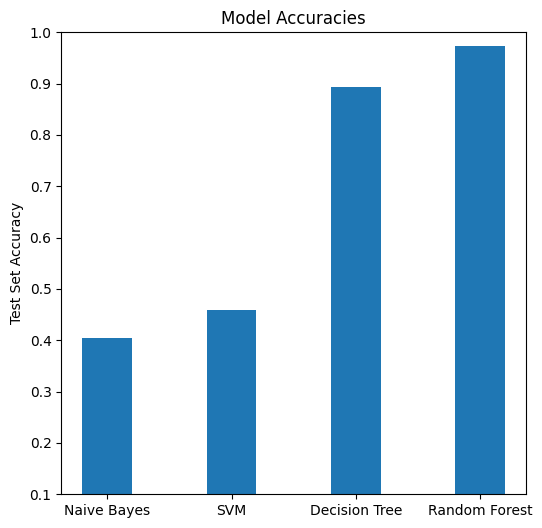

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Trained models
models = [nb_model, svm_model, dt_model, rf_model]

# Model names
names = ['Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest']

# Test set accuracies
accuracies = [nb_test_accuracy, svm_test_accuracy, dt_test_accuracy, rf_test_accuracy]

# Plot bar chart
plt.figure(figsize=(6, 6))
plt.bar(names, accuracies, width=0.4)

plt.title("Model Accuracies")
plt.ylabel("Test Set Accuracy")
plt.ylim([0.1, 1])

plt.show()

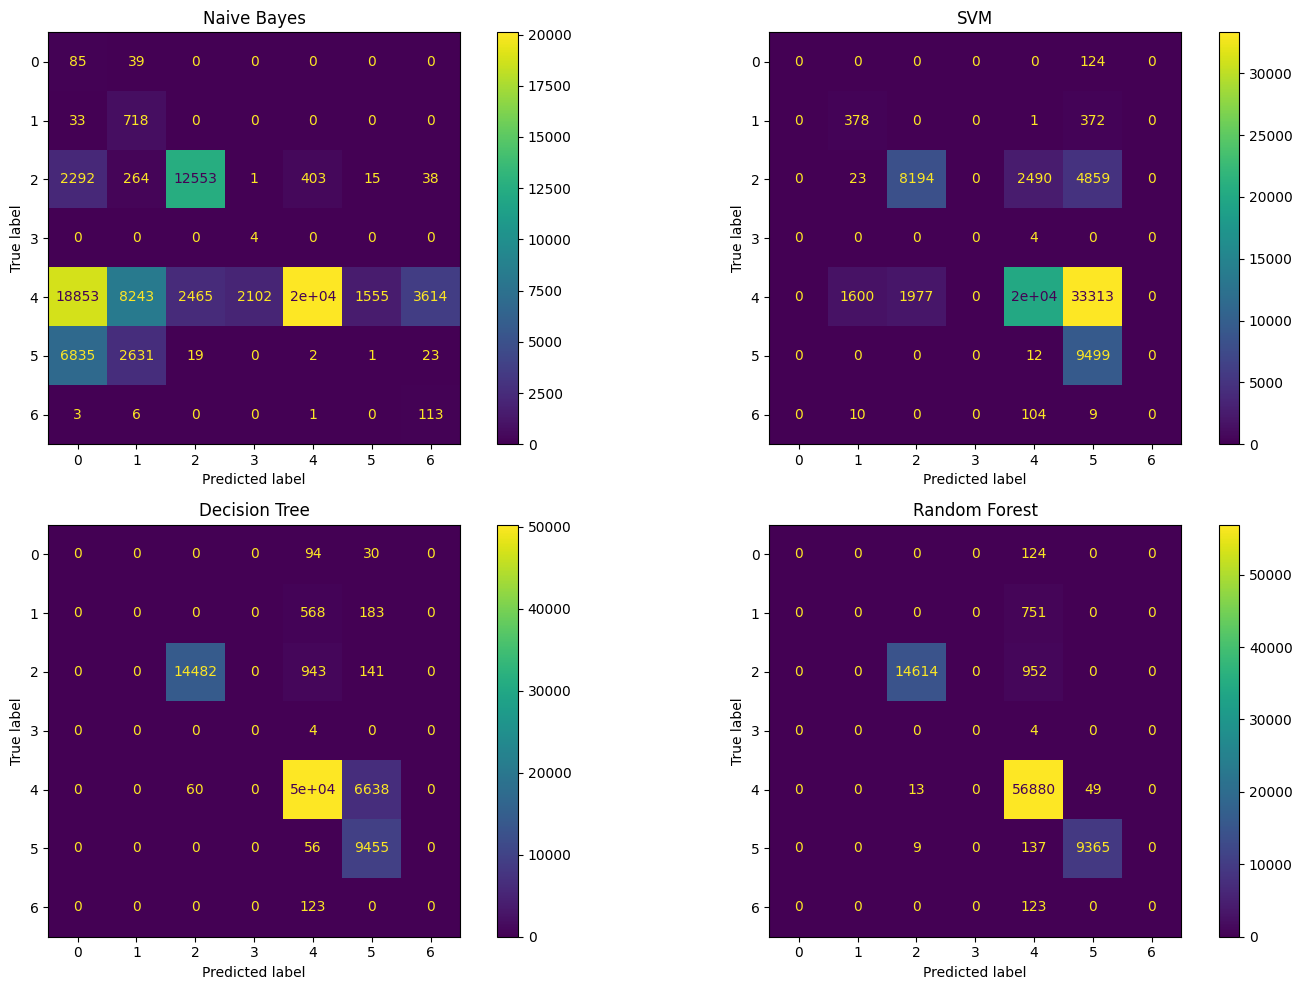

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = [nb_model, svm_model, dt_model, rf_model]
model_names = ["Naive Bayes", "SVM", "Decision Tree", "Random Forest"]

figure, axarr = plt.subplots(2, 2, figsize=(15, 10))

for i, (model, model_name) in enumerate(zip(models, model_names)):

    # Get test set predictions
    preds = model.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, preds)

    # Plot subplot
    ax = axarr[i//2, i%2]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax)

    ax.set_title(model_name)

figure.tight_layout()
plt.show()

## Graphical Comparison of Models Performance After Evasion Attack

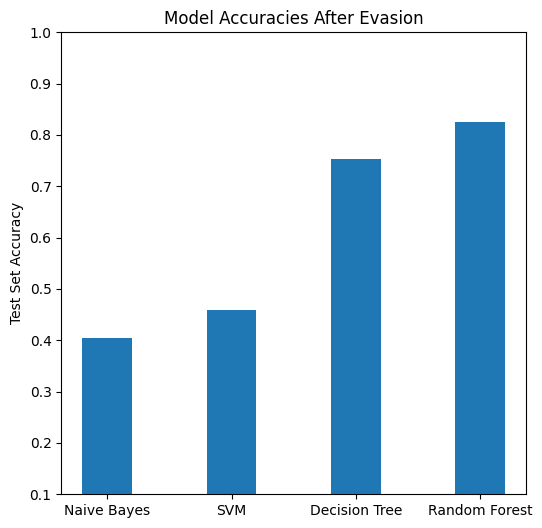

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# # Trained models
# models = [nb_model, svm_model, dt_model, rf_model]

# Model names
names = ['Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest']

# Test set accuracies
accuracies = [nb_evasion_accuracy, svm_evasion_accuracy, dt_evasion_accuracy, rf_evasion_accuracy]

# Plot bar chart
plt.figure(figsize=(6, 6))
plt.bar(names, accuracies, width=0.4)

plt.title("Model Accuracies After Evasion")
plt.ylabel("Test Set Accuracy")
plt.ylim([0.1, 1])

plt.show()

## Graphical Comparison of Models Performance After Poisoning Attack


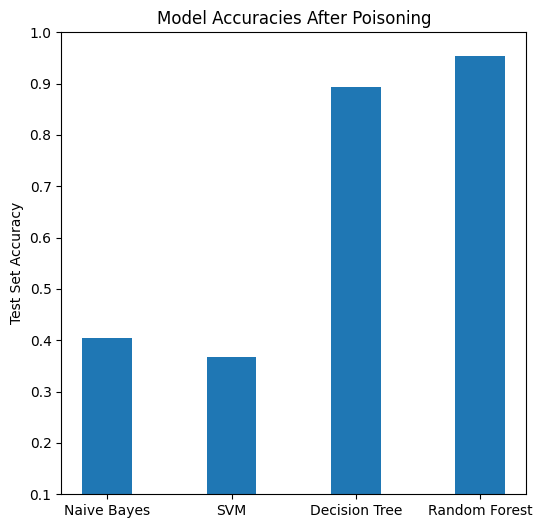

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# # Trained models
# models = [nb_model, svm_model, dt_model, rf_model]

# Model names
names = ['Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest']

# Test set accuracies
accuracies = [nb_poisoned_accuracy, svm_poisoned_accuracy, dt_poisoned_accuracy, rf_poisoned_accuracy]

# Plot bar chart
plt.figure(figsize=(6, 6))
plt.bar(names, accuracies, width=0.4)

plt.title("Model Accuracies After Poisoning")
plt.ylabel("Test Set Accuracy")
plt.ylim([0.1, 1])

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


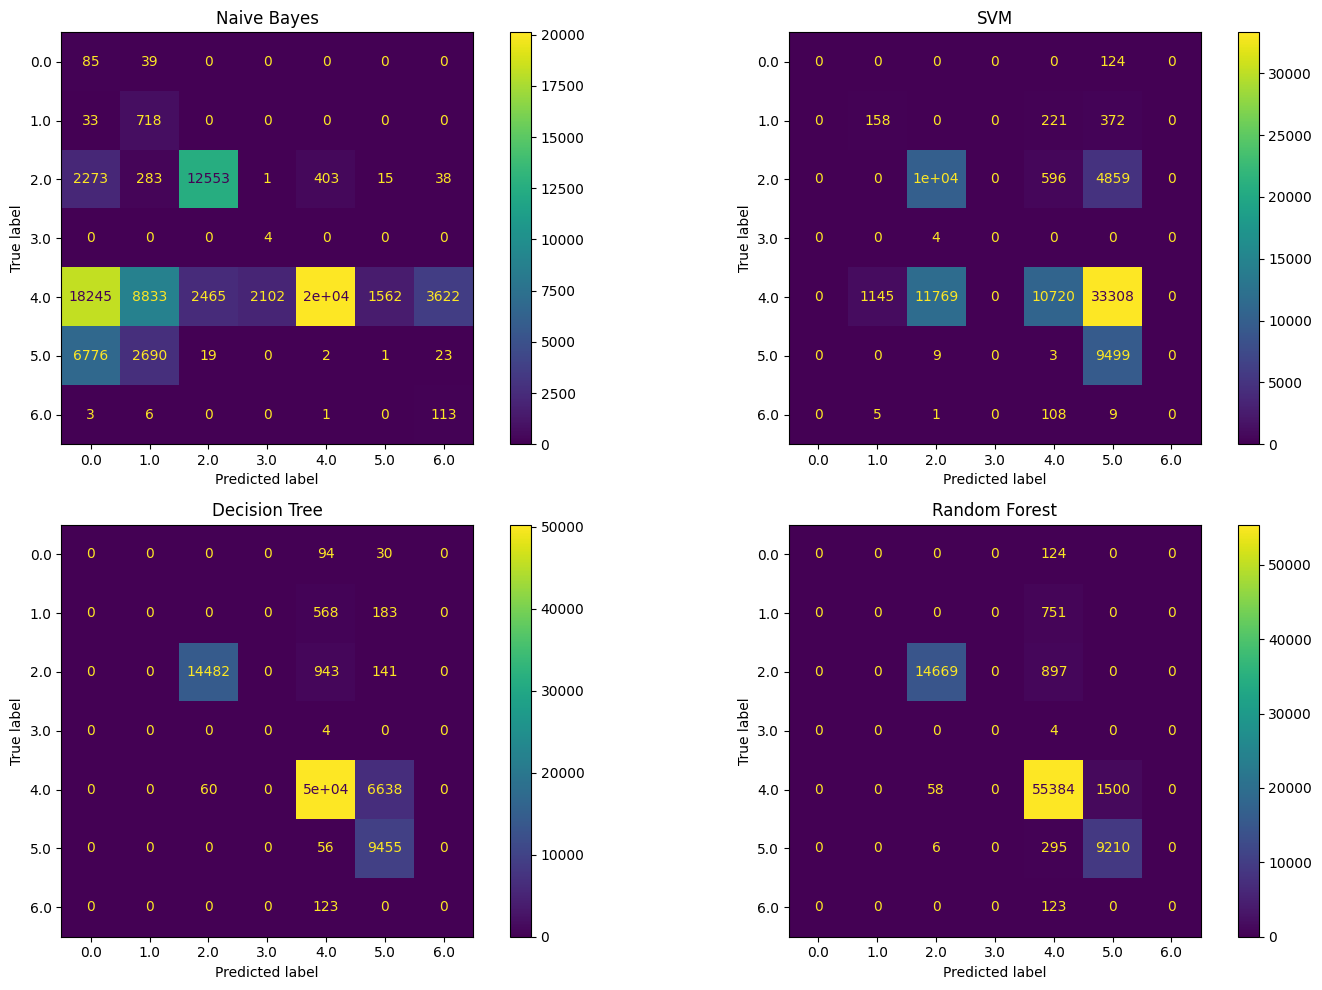

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = [nb_poisoned, svm_poisoned, dt_poisoned, rf_poisoned]
model_names = ["Naive Bayes", "SVM", "Decision Tree", "Random Forest"]

figure, axarr = plt.subplots(2, 2, figsize=(15, 10))

for i, (model, model_name) in enumerate(zip(models, model_names)):

    # Get test set predictions
    preds = model.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, preds)

    # Plot subplot
    ax = axarr[i//2, i%2]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax)

    ax.set_title(model_name)

figure.tight_layout()
plt.show()